In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [39]:
SEED = 5080

In [40]:
TCGA_data = pd.read_csv("../input/cidtcga/GDSC_TCGA_Docetaxel.csv")
TCGA_patient = pd.read_csv("../input/cidtcga/Patients_TCGA_Docetaxel.csv")
TCGA_data = TCGA_data.rename(columns = {'Unnamed: 0': 'gene_expression'})
TCGA_patient = TCGA_patient.rename(columns = {'Unnamed: 0': 'patient_id'})

# EDA

In [41]:
print(f"Training dataset shape = {TCGA_data.shape}")
print(f"Testing dataset shape = {TCGA_patient.shape}")

Training dataset shape = (850, 16170)
Testing dataset shape = (16, 16170)


In [42]:
if list(TCGA_data.columns[2:]) == list(TCGA_patient.columns[2:]):
    print("All features in training and testing dataset are the same!")
else:
    print("There are some different features in testing dataset")

All features in training and testing dataset are the same!


In [43]:
MAX_MEDICINE_LEVEL = 0.0125
TCGA_data["target"] = TCGA_data["IC50"].apply(
    lambda x: "R" if x > MAX_MEDICINE_LEVEL else "S"
    )

In [44]:
ratio = TCGA_data["target"].value_counts() / TCGA_data.shape[0]
print("Label distribution in TCGA dataset")
print(ratio * 100)

Label distribution in TCGA dataset
S    66.352941
R    33.647059
Name: target, dtype: float64


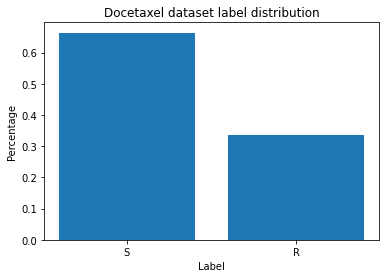

In [47]:
plt.xlabel("Label")
plt.ylabel("Percentage")
plt.bar(x = ratio.index, height=ratio)
plt.title("Docetaxel dataset label distribution")
plt.show()

# Data preprocessing

In [48]:
drop_cols = ["IC50", "gene_expression", "target"]
keep_cols = list(
    set(TCGA_data.columns) - set(drop_cols)
)
X = TCGA_data[keep_cols]
y = TCGA_data["target"]

In [49]:
print(X.shape)
print(y.shape)

(850, 16168)
(850,)


# Feature selection

### Logistic regression with L1 regularization

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

In [ ]:
clf = LogisticRegressionCV(
    cv=cv, penalty = "l1", solver="saga", random_state=SEED
    ).fit(X, y)

In [ ]:
acc = clf.score(X, y)
print(f"Training acc of best model = {round(acc * 100, 4)}%")
print("Cross Validation result in each parameter sets")
pd.DataFrame({"C":clf.Cs_, "Cross valid acc": clf.scores_["S"].mean(axis = 0)})

In [ ]:
logistic_regression_coefs = X.columns[(clf.coef_ > 0).flatten()]
print(f"There are {len(logistic_regression_coefs)} features selected by L1 logistic regression")
print(sorted(logistic_regression_coefs.tolist()))

## Anova F-test

In [ ]:
anova_selector = SelectKBest(score_func=f_classif, k=30)
anova_selector.fit(X, y)

In [ ]:
num_selected_features = 30
anova_df = pd.DataFrame({"feature_names":X.columns, "scores":anova_selector.scores_})
anova_df = anova_df.sort_values(by = ["scores"], ascending=False)
print(f"Top {num_selected_features} selected by anova classification are")
print(anova_df[:num_selected_features]["feature_names"].tolist())
anova_df[:num_selected_features]

In [ ]:
x = [i for i in range(len(anova_df["scores"]))]
plt.plot(x, anova_df["scores"])
plt.show()

In [ ]:
cols = ['ANKFY1', 'C2orf68', 'CEP128', 'CHST2', 'GABPA', 'GYS2', 'HDAC1', 'ITGA4', 'JARID2', 'MDM1', 'OLFML2A', 'PPP3CB', 'PRIM2', 'PRPF4B', 'PTGES3', 'RAP2B', 'SMC6', 'TIMELESS', 'TRDMT1', 'TRIM25', 'TSLP', 'UBE2G1', 'ZNF318']
anova_df[anova_df["feature_names"].isin(cols)]

## Random Forest

In [63]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
RF_params_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'oob_score': [True]}
print(RF_params_grid)

{'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2, 4], 'oob_score': [True]}


In [ ]:
RFC = RandomForestClassifier(random_state = SEED)
RFC_CV = GridSearchCV(estimator = RFC, param_grid = params_grid, cv = cv, verbose = 2)
RFC_CV.fit(X, y)

# Data preprocessing for selected features

In [50]:
L1_features = [
    'ADARB1', 'ADCY3', 'APIP', 'APOC1', 'APTX', 'ASMT', 'AWAT2', 
    'BID', 'C22orf42', 'C3orf67', 'C5', 'CCDC158', 'CCNC', 'CCT4', 'CD300LD', 
    'CDCA7', 'CDK5RAP2', 'CEP78', 'CHCHD4', 'CISD1', 'CNGB1', 'CNN2', 'COL27A1', 
    'COL7A1', 'COPS2', 'CSNK1E', 'DDIT4L', 'DGKK', 'DUSP9', 'EIF3A', 'ELP4', 'ETF1', 
    'EXT2', 'F10', 'FAHD2A', 'FAM20C', 'FBLN1', 'FBXO30', 'FKBP15', 'FOXL2', 'GABRA4', 
    'GART', 'GFM2', 'GFPT2', 'GGCT', 'GLI1', 'GPR153', 'GRHPR', 'GSDMD', 'HACL1', 'HDAC1', 
    'HIBADH', 'HLA.DPB2', 'HSP90AB1', 'IGF2BP2', 'IGFBP6', 'IL11', 'INSL3', 'INVS', 'IPO7', 
    'ITPRIP', 'KCNJ1', 'KIF18A', 'KREMEN2', 'LIPG', 'LLGL1', 'MAFF', 'MDFI', 'MEDAG', 'MFAP2', 
    'MFF', 'MPLKIP', 'MROH7', 'MRPS24', 'NAA50', 'NDUFAF7', 'NEIL1', 'NPM1', 'NQO2', 'NTNG2', 
    'OMG', 'ORC2', 'PACSIN3', 'PALM3', 'PDHX', 'PDLIM4', 'PHGDH', 'PITX1', 'PLD2', 'PMS1', 
    'PPP1CB', 'PRTG', 'RAB34', 'RASA2', 'REP15', 'RGP1', 'RNF8', 'RPAP1', 'RPP25L', 'SAAL1', 
    'SAR1A', 'SEMA4A', 'SERPINB3', 'SGK1', 'SH3BP5', 'SIM2', 'SLC15A2', 'SLC29A4', 'SMARCA1', 
    'SMU1', 'SNX3', 'SOCS2', 'STARD6', 'STOML2', 'SUPT7L', 'SYCP2L', 'TKTL2', 'TMEM184B', 
    'TRPM3', 'TSNAXIP1', 'UBAP1', 'URB1', 'ZNF558', 'ZNF717', 'ZNF846'
    ]
Anova_features = ['ABCB1', 'GPX8', 'YAP1', 'IGF2BP2', 
                  'MYRIP', 'IGFBP6', 'RAB31', 'EXT2', 
                  'ZNF124', 'BAG3', 'GFPT2', 'COL7A1', 
                  'SEC11C', 'PACSIN3', 'FAM20C', 'CAV1', 
                  'AXL', 'BCAR3', 'PRNP', 'RRAS', 'RAB34', 
                  'CAV2', 'ATP8A1', 'UCP2', 'EMP1', 'HEG1', 
                  'PTGR1', 'RAB11FIP5', 'PDLIM4', 'PARVA'
                 ]

RF_features = [
    'ABCB1', 'GFPT2', 'IGFBP6', 'PACSIN3', 'COL7A1', 'EXT2', 
    'BCL2', 'DDC', 'YAP1', 'GPX8', 'PLS3', 'SERPINE1', 'GGCX', 
    'COG2', 'PTGR1', 'ITPRIP', 'ADAMTSL2', 'PTPRO', 'WWTR1', 'OR51E1', 
    'MYRIP', 'IGF2BP2', 'TPM2', 'NOL4'
]

L1_set = set(L1_features)
Anova_set = set(Anova_features)
RF_set = set(RF_features)

union_features = L1_set | Anova_set | RF_set
intersect_features = L1_set & Anova_set & RF_set
print(f"Number of union features = {len(union_features)}")
print(f"Number of intersect features = {len(intersect_features)}")

Number of union features = 158
Number of intersect features = 6


In [145]:
final_features = list(union_features)
X_train = TCGA_data[final_features]
y_train = TCGA_data["target"]
X_test = TCGA_patient[final_features]
y_test = TCGA_patient["label"]

SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

In [57]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(850, 158)
(850,)
(16, 158)
(16,)


# Modeling

### Level One Model - hyperparameter tuning
- Ridge Regression
- Random Forest
- XGboost
- Support Vector Machine
- KNN

In [ ]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=SEED)

In [60]:
#Ridge regression 
clf_LG = LogisticRegressionCV(
    cv=cv, penalty = "l2", 
    random_state=SEED, solver='liblinear'
    ).fit(X_train, y_train)
acc = clf_LG.score(X_train, y_train)

In [64]:
#Random forest
RFC = RandomForestClassifier(random_state = SEED)
RFC_CV = GridSearchCV(
    estimator = RFC, param_grid = RF_params_grid, 
    cv = cv, verbose = 1, n_jobs = -1
    )
RFC_CV.fit(X_train, y_train)

Fitting 15 folds for each of 180 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 23.6min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 26.4min finished


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=5080),
             estimator=RandomForestClassifier(random_state=5080), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'oob_score': [True]},
             verbose=1)

In [66]:
#SVM
SVM_param_grid = {
    'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
    }

SVC_clf = SVC()
SVC_grid = GridSearchCV(SVC_clf, SVM_param_grid, refit=True, verbose=1)
SVC_grid.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   27.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=1)

In [67]:
#KNN
k_max = round(np.sqrt(X_train.shape[0]))
k_range = list(range(3, k_max, 3))
KNN_param_grid = {
    "n_neighbors": k_range,
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

KNN = KNeighborsClassifier()
KNN_grid = GridSearchCV(
    KNN, 
    KNN_param_grid, 
    verbose = 1,
    cv = cv, n_jobs = -1
).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 15 folds for each of 36 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:    9.9s finished


# Stacking model

In [108]:
L2REG = LogisticRegression(C = clf_LG.C_[0], penalty = "l2")
RF = RandomForestClassifier(**RFC_CV.best_params_, random_state = SEED)
SVM = SVC(**SVC_grid.best_params_)
KNN = KNeighborsClassifier(**KNN_grid.best_params_)
base_learners = [
    ("Ridge", L2REG),
    ("RF", RF),
    ("SVM", SVM),
    ("KNN", KNN)
]

stack_clf = StackingClassifier(
    estimators = base_learners, 
    final_estimator = LogisticRegression(),
    cv = 10,
    n_jobs = -1,
    verbose = 1
)

stack_clf.fit(X_train, y_train)

StackingClassifier(cv=10,
                   estimators=[('Ridge',
                                LogisticRegression(C=0.046415888336127774)),
                               ('RF',
                                RandomForestClassifier(max_depth=9,
                                                       min_samples_split=5,
                                                       n_estimators=500,
                                                       oob_score=True,
                                                       random_state=5080)),
                               ('SVM', SVC(C=1, gamma=0.001)),
                               ('KNN',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=18,
                                                     weights='distance'))],
                   final_estimator=LogisticRegression(), n_jobs=-1, verbose=1)

In [109]:
train_acc = stack_clf.score(X_train, y_train)
print(f"Training accuracy of stack classifier = {train_acc}")

Training accuracy of stack classifier = 0.84


In [115]:
stack_clf.classes_

array(['R', 'S'], dtype=object)

# Inference
- R:0, S:1

In [171]:
# y_train_pred = stack_clf.decision_function(X_train)
# y_test_pred = stack_clf.decision_function(X_test)
y_train_pred = stack_clf.predict_proba(X_train)[:, 1]
y_test_pred = stack_clf.predict_proba(X_test)[:, 1]

In [172]:
y_train_trans = [0 if i == "R" else 1 for i in y_train]

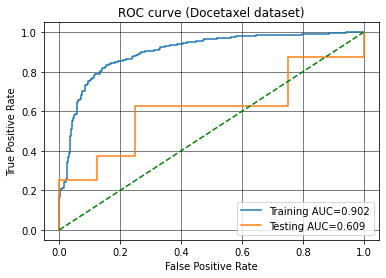

In [180]:
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_trans, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(1 - y_test, y_test_pred)

train_AUC = auc(train_fpr, train_tpr)
test_AUC = auc(test_fpr, test_tpr)

plt.plot(
    train_fpr, train_tpr, 
    label = f"Training AUC={round(train_AUC, 3)}"
    )
plt.plot(
    test_fpr, test_tpr, 
    label = f"Testing AUC={round(test_AUC, 3)}"
    )
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve (Docetaxel dataset)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()